In [1]:
import os, glob
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import RFormula
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.5, rc={'text.usetex' : True})

sc = SparkContext('local')
spark = SparkSession(sc)

path = "./input/clean/training_data/"

In [2]:
NC_data = spark.read.csv(path + "NOAA_NC_DAvg_training_data.csv", header=True, inferSchema=True)
NC_data = NC_data.drop(*[t for t in NC_data.columns if t[-1] == 'T']+['date','CLASS'])
NC_data = NC_data.drop(*["MaxTemp", "MinTemp", "MaxRH", "MinRH", "MaxBP", "MinBP","MaxWSpd","MinWSpd"])
NC_data.show(5)

+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+
|             ATemp|               RH|                BP|              WSpd|              Wdir|            SDWDir|             TotPrcp|            TotPAR|           AvgVolt|              Temp|
+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+
| 8.296874999999998|71.97916666666667|           1027.75|1.3093750000000004|249.76041666666666|             17.25|                 0.0|204.30624999999995|13.016666666666666|10.641145833333328|
|11.064583333333331|71.29166666666667|1024.4583333333333|1.7385416666666673|249.57291666666666|16.197916666666668|0.003124999999999...|173.65000000000006|12.969791666666666|11.089062499999999|
|15.534374999999997|          71.18

In [3]:
# vector of features
rf = RFormula(formula="Temp~.")
vector_rf = rf.fit(NC_data).transform(NC_data).select(["features","label"])
vector_rf.show(5)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[8.29687499999999...|10.641145833333328|
|[11.0645833333333...|11.089062499999999|
|[15.5343749999999...|12.167708333333321|
|[19.1302083333333...|13.960937499999993|
|[19.6677083333333...|15.548437499999999|
+--------------------+------------------+
only showing top 5 rows



In [4]:
train,test = vector_rf.randomSplit([0.80,0.20],42069)

In [55]:
# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features", maxDepth = 10, numTrees = 100)

# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+-----------------+------------------+--------------------+
|       prediction|             label|            features|
+-----------------+------------------+--------------------+
|7.669772301795347|         4.5515625|[-0.3041666666666...|
|8.952476385450046|6.6705882352941135|[0.91458333333333...|
|7.682614662159945| 5.864583333333335|[1.20937500000000...|
|9.157815515898045| 6.894791666666664|[1.87105263157894...|
|9.221053285714893| 4.579166666666668|[2.24687499999999...|
+-----------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.92561


In [56]:
def cartesian_grid(depth, treen):

    depth_range = np.arange(1, depth, 2)

    treen_range = np.arange(1, treen, 10)

    return [(a, b) for a in depth_range for b in treen_range]

In [57]:
rf_rmse = []
grid = cartesian_grid(15,200)
for value in grid:
    rf = RandomForestRegressor(featuresCol="features", maxDepth = value[0], numTrees = value[1])
    model = rf.fit(train)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rf_rmse.append(evaluator.evaluate(predictions))

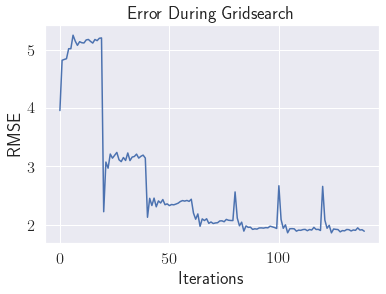

In [58]:
sns.lineplot(range(0,140), rf_rmse)
plt.title("Error During Gridsearch")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.savefig("./images/rfrmse_plot.png")

In [ ]:
rf_rmse.index(min(rf_rmse))
print(grid[124], grid[85])

In [ ]:
rf = RandomForestRegressor(featuresCol="features", maxDepth = 9, numTrees = 51)
model = rf.fit(train)
predictions = model.transform(test)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator.evaluate(predictions)

In [5]:
rf = RandomForestRegressor(featuresCol="features", maxDepth = 13, numTrees = 41)
model = rf.fit(train)
predictions = model.transform(test)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator.evaluate(predictions)

1.9495019329428223

In [6]:
pred = predictions.toPandas()
test_pd = test.toPandas()

Text(0.5, 0, 'Index')

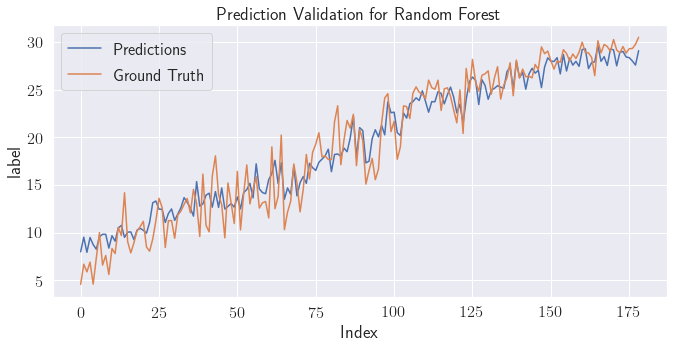

In [13]:
dims = (11,5)
fig, ax = plt.subplots(figsize = dims)
sns.lineplot(pred.index,pred.prediction, label="Predictions", ax = ax)
sns.lineplot(pred.index, test_pd.label,label="Ground Truth", ax = ax)
plt.title("Prediction Validation for Random Forest")
plt.xlabel("Index")

Text(0.5, 0, 'Index')

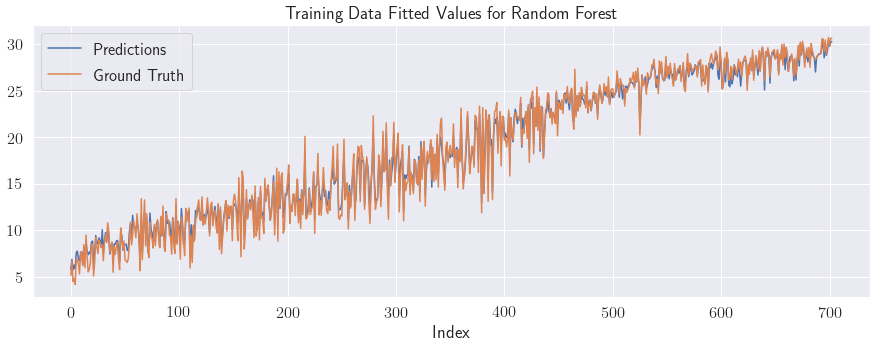

In [24]:
prediction_train = model.transform(train)
pred_train = prediction_train.toPandas()
train_pd = train.toPandas()
dims = (15,5)
fig, ax = plt.subplots(figsize = dims)
sns.lineplot(data = pred_train.prediction, label="Predictions", ax = ax)
sns.lineplot(data = train_pd.label,label="Ground Truth", ax = ax)
plt.title("Training Data Fitted Values for Random Forest")
plt.xlabel("Index")

In [20]:
pred_train

,features,label,prediction
0,"[-3.7364583333333328, 42.885416666666664, 1036...",5.170833,5.836573
1,"[-3.577083333333333, 47.020833333333336, 1018....",6.731250,6.890862
2,"[-2.4343749999999997, 51.270833333333336, 1029...",4.523958,5.732833
3,"[-1.9656249999999995, 54.291666666666664, 1036...",4.840625,6.283067
4,"[-0.8885416666666665, 45.229166666666664, 1022...",4.209896,5.902130
...,...,...,...
698,"[29.314583333333335, 79.65625, 1008.125, 3.291...",29.788542,29.290320
699,"[29.554736842105296, 81.93684210526315, 1014.0...",30.727083,30.353821
700,"[29.578723404255314, 81.96808510638297, 1012.2...",29.796528,29.761230
701,"[29.878125, 81.63541666666667, 1015.25, 2.1062...",30.620312,30.180952
